In [54]:
import torch

# Check for GPU availability
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using GPU: NVIDIA RTX A4000


Total number of training images in subset: 50000
Total number of testing images in subset: 2000
Loaded batch size: 64
Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


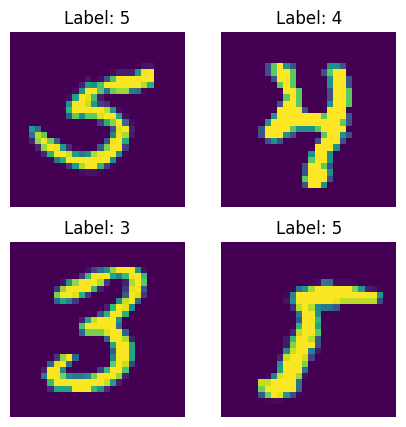

In [55]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for MNIST
transform = transforms.Compose([
    # transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor()         # Scales images to [0, 1]
])

# Load MNIST dataset with the new transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Subset the datasets to include only a set number of examples
num_samples_train = 50000  # Number of samples to include in the training subset
num_samples_test = 2000   # Number of samples to include in the testing subset

indices_train = np.random.choice(len(train_dataset), num_samples_train, replace=False)
indices_test = np.random.choice(len(test_dataset), num_samples_test, replace=False)

subset_train_dataset = Subset(train_dataset, indices_train)
subset_test_dataset = Subset(test_dataset, indices_test)

print(f"Total number of training images in subset: {len(subset_train_dataset)}")
print(f"Total number of testing images in subset: {len(subset_test_dataset)}")

# Create data loaders with subsets
train_loader = DataLoader(subset_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(subset_test_dataset, batch_size=64, shuffle=False)

# Example of accessing and plotting the first batch of images
for images, labels in train_loader:
    print(f"Loaded batch size: {images.shape[0]}")
    print(f"Images shape: {images.shape}")  # Shape of images in a batch
    print(f"Labels shape: {labels.shape}")  # Shape of labels in a batch

    # Displaying a few example images from the batch
    plt.figure(figsize=(5, 5))
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break  # Only process the first batch


In [56]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Initial layer going to 7x7
            nn.ConvTranspose2d(nz, 128, 7, 1, 0, bias=False),  # Output size: 7x7
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # First upsample to 14x14
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # Output size: 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Second upsample to 28x28
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),    # Output size: 28x28
            nn.Sigmoid()
        )

    def forward(self, input):
        x = input
        for i, layer in enumerate(self.main):
            x = layer(x)
            # print(f"Stage {i+1}, Output size: {x.size()}")
        return x

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Reduce from 28x28 to 14x14
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Reduce from 14x14 to 7x7
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Reduce from 7x7 to 3x3
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Finally to 1x1
            nn.Conv2d(256, 1, 3, 1, 0, bias=False),  # Adjust kernel to match the final output size of 3x3
            nn.Sigmoid()
        )

    def forward(self, input):
        x = input
        for i, layer in enumerate(self.main):
            x = layer(x)
            # print(f"Stage {i+1}, Output size: {x.size()}")
        return x.view(-1)


In [57]:
# import torch
# import torch.nn as nn

# class Generator(nn.Module):
#     def __init__(self, nz):
#         super(Generator, self).__init__()
#         self.main = nn.Sequential(
#             # Initial layer going to 7x7
#             nn.ConvTranspose2d(nz, 256, 7, 1, 0, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
#             # Upsample to 14x14
#             nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
#             # Upsample to 28x28
#             nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             # Final layer to maintain size 28x28
#             nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),  # Correct stride and padding
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         x = input
#         for i, layer in enumerate(self.main):
#             x = layer(x)
#             # print(f"Generator Stage {i+1}, Output size: {x.size()}")
#         return x


# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             # Initial layer to process 28x28
#             nn.Conv2d(1, 64, 4, 2, 1, bias=False),  # Output size: 14x14
#             nn.LeakyReLU(0.2, inplace=True),
#             # Reduce to 14x14
#             nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # Output size: 7x7
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             # Reduce to 7x7
#             nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # Output size: 3x3
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             # Final layer to reduce to 1x1
#             nn.Conv2d(256, 1, 3, 1, 0, bias=False),  # Corrected to fit 3x3 input
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         x = input
#         for i, layer in enumerate(self.main):
#             x = layer(x)
#             # print(f"Discriminator Stage {i+1}, Output size: {x.size()}")
#         return x.view(-1)


In [58]:
# import torch
# import torch.nn as nn

# class Generator(nn.Module):
#     def __init__(self, nz):
#         super(Generator, self).__init__()
#         self.main = nn.Sequential(
#             # Initial layer going to 7x7
#             nn.ConvTranspose2d(nz, 512, 7, 1, 0, bias=False),
#             nn.BatchNorm2d(512),
#             nn.ReLU(True),
#             # Reduce to 256 channels
#             nn.ConvTranspose2d(512, 256, 1, 1, 0, bias=False),  # 1x1 convolution for channel reduction
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
#             # Upsample to 14x14
#             nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
#             # Upsample to 28x28
#             nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             # Final layer to maintain size 28x28
#             nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         x = input
#         for i, layer in enumerate(self.main):
#             x = layer(x)
#             # print(f"Generator Stage {i+1}, Output size: {x.size()}")
#         return x

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             # Initial layer to process 28x28
#             nn.Conv2d(1, 64, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # Reduce to 14x14
#             nn.Conv2d(64, 128, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             # Reduce to 7x7
#             nn.Conv2d(128, 256, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             # Introduce 512-layer
#             nn.Conv2d(256, 512, 3, 1, 1, bias=False), 
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2, inplace=True),
#             # Final layer to reduce to 1x1
#             nn.Conv2d(512, 1, 3, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         x = input
#         for i, layer in enumerate(self.main):
#             x = layer(x)
#             # print(f"Discriminator Stage {i+1}, Output size: {x.size()}")
#         return x.view(-1)


In [59]:
# # Parameters
# nz = 100  # Example latent dimension size

# # Model instantiation
# generator = Generator(nz)
# discriminator = Discriminator()

# # Test with random noise
# random_noise = torch.randn(1, nz, 1, 1)
# fake_image = generator(random_noise)
# disc_output = discriminator(fake_image)

# print("Final Generated Image Size:", fake_image.size())  # Expected: [1, 1, 28, 28]
# print("Final Discriminator Output Size:", disc_output.size())  # Expected: [1]


In [60]:
# nz = 100  # dimension of the latent vector
# batch_size = 32

# # Initialize the discriminator and generator
# D = Discriminator()
# G = Generator(nz)

# # Test the discriminator
# input_tensor = torch.randn(batch_size, 1, 32, 32)  # fake input image
# output = D(input_tensor)
# print(f"Discriminator output shape: {output.shape}")

# # Test the generator
# noise = torch.randn(batch_size, nz, 1, 1)  # random latent vector
# generated_image = G(noise)
# print(f"Generated image shape: {generated_image.shape}")

In [61]:
# noise = torch.randn(batch_size, nz, 1, 1, device=device)
# fake_images = generator(noise)
# print("Fake Images Shape:", fake_images.shape)  # Ensure this is [batch_size, channels, height, width]

# output_fake = discriminator(fake_images.detach())
# print("Output Fake Shape:", output_fake.shape)  # Debug statement


In [62]:
# import torch
# from torch import nn
# import torch.optim as optim
# from tqdm.notebook import tqdm

# # Assuming the Generator and Discriminator have been defined and imported as per your last implementation.

# # Device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initialize the generator and discriminator
# nz = 100  # Size of z latent vector (i.e., size of generator input)
# generator = Generator(nz).to(device)
# discriminator = Discriminator().to(device)

# # Setup Loss function and Optimizers
# criterion = nn.BCELoss()
# optimizerD = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
# optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# # Training loop
# num_epochs = 50
# real_label = 1.0
# fake_label = 0.0

# for epoch in range(num_epochs):
#     loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
#     for i, (real_images, _) in loop:
#         batch_size = real_images.size(0)

#         # Prepare real data
#         real_images = real_images.to(device)
#         label_real = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

#         # Update discriminator on real data
#         discriminator.zero_grad()
#         output_real = discriminator(real_images)
#         errD_real = criterion(output_real, label_real)
#         errD_real.backward()
#         D_x = output_real.mean().item()

#         # Prepare fake data
#         noise = torch.randn(batch_size, nz, 1, 1, device=device)
#         fake_images = generator(noise)
#         label_fake = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)

#         # Update discriminator on fake data
#         output_fake = discriminator(fake_images.detach())
#         errD_fake = criterion(output_fake, label_fake)
#         errD_fake.backward()
#         D_G_z1 = output_fake.mean().item()

#         # Discriminator optimization step
#         optimizerD.step()

#         # Update generator
#         generator.zero_grad()
#         label_gen = torch.full((batch_size,), real_label, dtype=torch.float, device=device)  # Generators try to deceive the discriminator
#         output_gen = discriminator(fake_images)
#         errG = criterion(output_gen, label_gen)
#         errG.backward()
#         D_G_z2 = output_gen.mean().item()

#         optimizerG.step()

#         # Update tqdm loop display
#         loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
#         loop.set_postfix(loss_d=(errD_real + errD_fake).item(), loss_g=errG.item(), D_x=D_x, D_G_z1=D_G_z1, D_G_z2=D_G_z2)

#     loop.close()

# print("Training finished!")



In [63]:
import torch
from torch import nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Assuming the Generator and Discriminator have been defined and imported as per your last implementation.

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the generator and discriminator
nz = 100  # Size of z latent vector (i.e., size of generator input)
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

# Setup Loss function and Optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0006, betas=(0.5, 0.999))

# Training loop
num_epochs = 75
real_label = 1.0
fake_label = 0.0

# Lists to store metrics
loss_d_values = []
loss_g_values = []
D_x_values = []
D_G_z1_values = []
D_G_z2_values = []

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for i, (real_images, _) in loop:
        batch_size = real_images.size(0)

        # Prepare real data
        real_images = real_images.to(device)
        label_real = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        # Update discriminator on real data
        discriminator.zero_grad()
        output_real = discriminator(real_images)
        errD_real = criterion(output_real, label_real)
        errD_real.backward()
        D_x = output_real.mean().item()

        # Prepare fake data
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = generator(noise)
        label_fake = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)

        # Update discriminator on fake data
        output_fake = discriminator(fake_images.detach())
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()

        # Discriminator optimization step
        optimizerD.step()

        # Update generator
        generator.zero_grad()
        label_gen = torch.full((batch_size,), real_label, dtype=torch.float, device=device)  # Generators try to deceive the discriminator
        output_gen = discriminator(fake_images)
        errG = criterion(output_gen, label_gen)
        errG.backward()
        D_G_z2 = output_gen.mean().item()

        optimizerG.step()

        # Collect metrics
        loss_d = (errD_real + errD_fake).item()
        loss_g = errG.item()

        loss_d_values.append(loss_d)
        loss_g_values.append(loss_g)
        D_x_values.append(D_x)
        D_G_z1_values.append(D_G_z1)
        D_G_z2_values.append(D_G_z2)

        # Update tqdm loop display
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss_d=loss_d, loss_g=loss_g, D_x=D_x, D_G_z1=D_G_z1, D_G_z2=D_G_z2)

    loop.close()

print("Training finished!")

# Save the collected metrics
torch.save({
    'loss_d': loss_d_values,
    'loss_g': loss_g_values,
    'D_x': D_x_values,
    'D_G_z1': D_G_z1_values,
    'D_G_z2': D_G_z2_values,
}, 'training_metrics.pth')


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Training finished!


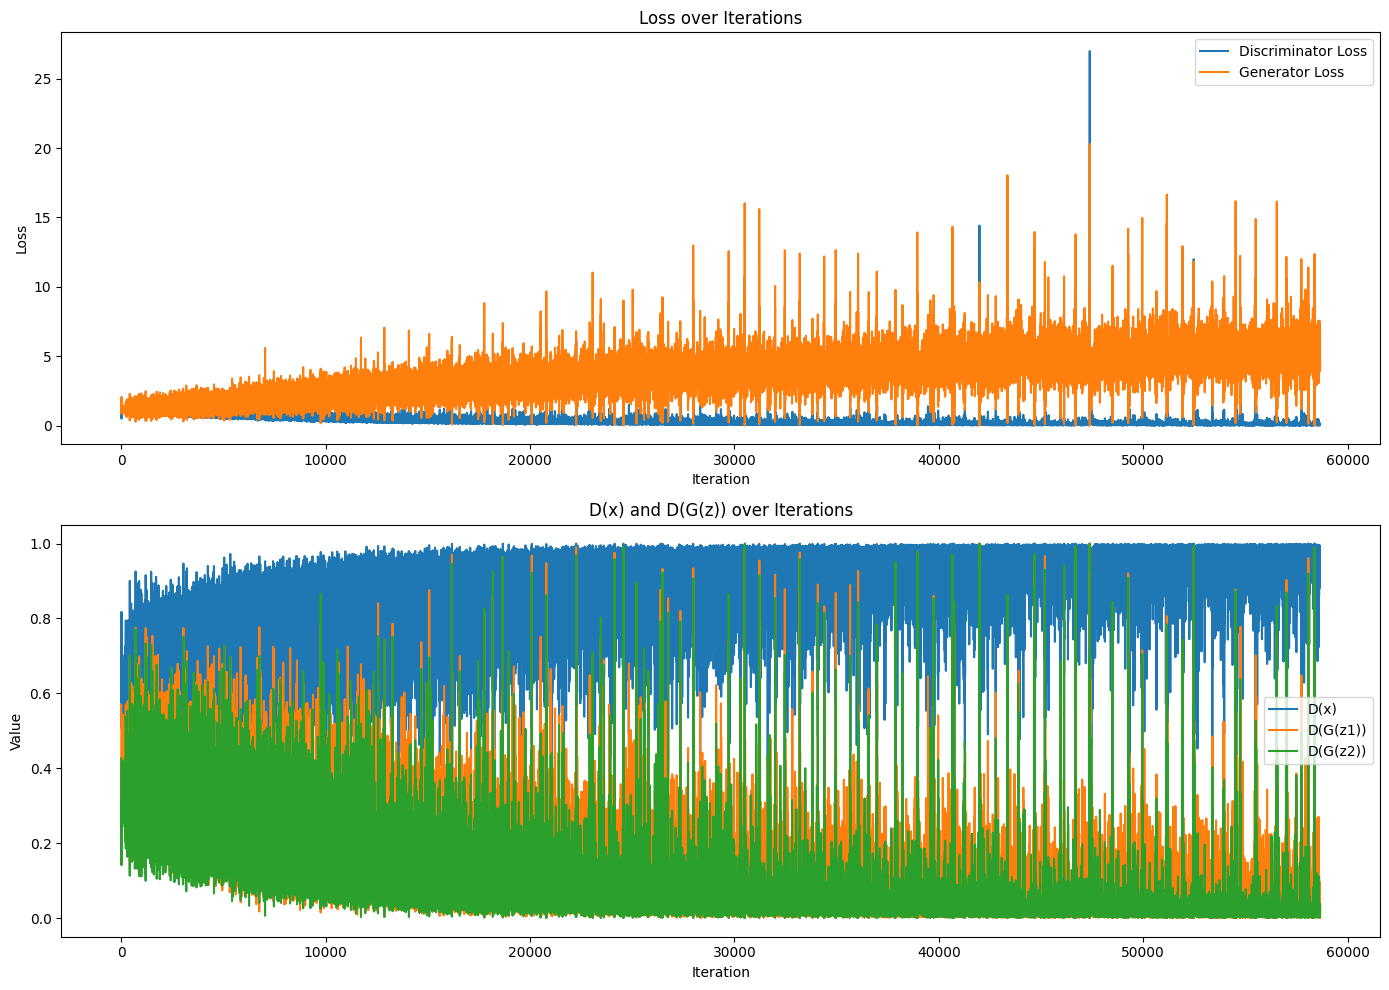

In [64]:
# Load the collected metrics
metrics = torch.load('training_metrics.pth')

# Extract the metrics
loss_d_values = metrics['loss_d']
loss_g_values = metrics['loss_g']
D_x_values = metrics['D_x']
D_G_z1_values = metrics['D_G_z1']
D_G_z2_values = metrics['D_G_z2']

# Plot the metrics
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(loss_d_values, label='Discriminator Loss')
plt.plot(loss_g_values, label='Generator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Iterations')

plt.subplot(2, 1, 2)
plt.plot(D_x_values, label='D(x)')
plt.plot(D_G_z1_values, label='D(G(z1))')
plt.plot(D_G_z2_values, label='D(G(z2))')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.title('D(x) and D(G(z)) over Iterations')

plt.tight_layout()
plt.show()


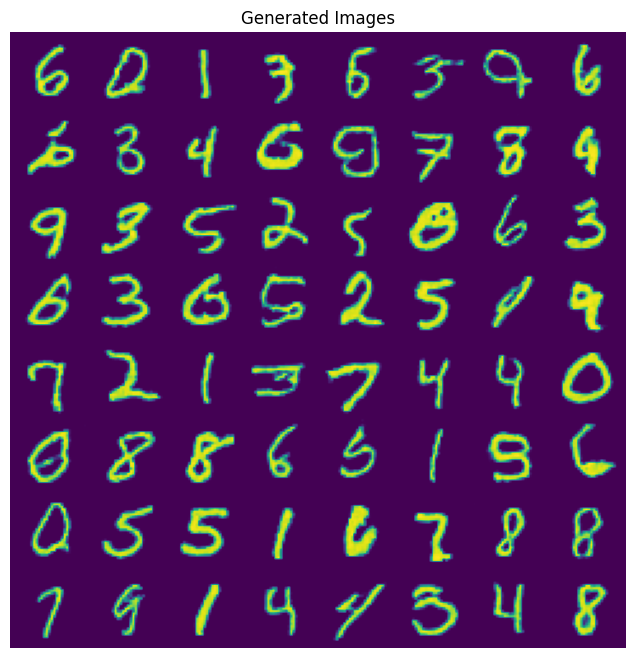

In [70]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming nz and device are defined
# nz = size of the latent vector, device = 'cuda' or 'cpu'

# After every epoch or at a set interval, generate images to see the progress
with torch.no_grad():
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    fake_images = generator(fixed_noise).detach().cpu()
    # Use make_grid to create a grid layout of images
    grid = make_grid(fake_images, padding=2, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    # Convert tensor to numpy and transpose the axes for correct image display
    grid_np = np.transpose(grid.numpy(), (1, 2, 0))
    # Convert to grayscale by averaging the color channels
    grid_gray = np.mean(grid_np, axis=2)
    # Apply the viridis colormap
    plt.imshow(grid_gray, cmap='viridis')
    plt.show()


In [66]:
# # Saving the Generator
# torch.save(generator.state_dict(), 'mnist512_gan_generator_state.pth')

# # Saving the Discriminator
# torch.save(discriminator.state_dict(), 'mnist512_gan_discriminator_state.pth')



In [67]:
# # Initialize the generator and discriminator
# generator = Generator(nz).to(device)
# discriminator = Discriminator().to(device)


# # Load the state dictionaries
# generator.load_state_dict(torch.load('mnist512_gan_generator_state.pth'))  # Correct file for the generator
# discriminator.load_state_dict(torch.load('mnist512_gan_discriminator_state.pth'))  # Correct file for the discriminator

# # Set to evaluation mode for inference
# generator.eval()
# discriminator.eval()
